In [1]:
# Fix randomness and hide warnings
seed = 42
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [2]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [10]:
# Import other libraries
import cv2
from tensorflow.keras.applications.xception import preprocess_input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import pickle
from DataLoader import load_data
from sklearn.utils import shuffle


Removing trolls, shreks and duplicates


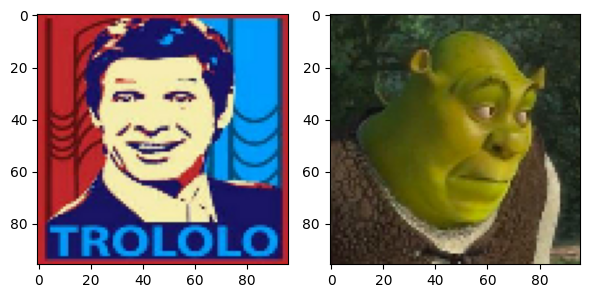

Removed Images: 350


In [4]:
(X_train, y_train), (X_test, y_test), (X_val, y_val) = load_data(test_size=0, val_size=0.0, seed=seed)

In [5]:
np.unique(y_train, return_counts=True)

(array([0., 1.], dtype=float32), array([3060, 1790]))

In [6]:
mask = y_train == 0
X_train_neg = X_train[mask]
X_train_pos = X_train[~mask]
y_train_neg = y_train[mask]
y_train_pos = y_train[~mask]



In [7]:
mask_index = random.sample(range(len(X_train_neg)), len(X_train_pos))
mask = np.zeros(len(X_train_neg), dtype=bool)
mask[mask_index] = True
X_train_neg = X_train_neg[mask]
y_train_neg = y_train_neg[mask]

In [8]:
X_train_equal = np.concatenate((X_train_pos, X_train_neg))
y_train_equal = np.concatenate((y_train_pos, y_train_neg))

In [9]:
#X_train, X_test, y_train, y_test = train_test_split(
#        X_train_equal, y_train_equal, random_state=seed, test_size=0.2, stratify=y_train_equal, shuffle=True)

In [11]:
X_train, y_train = shuffle(X_train_equal, y_train_equal)

In [12]:
data_augmentation = tfk.Sequential([
    tfkl.RandomFlip("horizontal"),
    tfkl.RandomRotation(0.2),
])

heavy_data_augmentation = tfk.Sequential([
    tfkl.RandomFlip("horizontal_and_vertical"),
    tfkl.RandomRotation(0.5),
])

In [13]:
def getXceptionModel_TL(data_augmentation):
    base_model = tfk.applications.Xception(
        input_shape=(96, 96, 3),
        include_top=False,
        weights="imagenet",
    )
    base_model.trainable = False
    inputs = tfk.Input(shape=(96, 96, 3))
    x = data_augmentation(inputs)
    scale_layer = tfkl.Rescaling(scale = 1/127.5, offset=-1)
    x = scale_layer(x)

    x = base_model(x, training=False)
    x = tfkl.GlobalAveragePooling2D()(x)
    x = tfkl.Dropout(0.2)(x)

    output = tfkl.Dense(2, activation="softmax")(x)
    model = tfk.Model(inputs, output)
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

    return model

In [14]:
def getXceptionModel_FT_6(model: tfk.Model):
    from_layer_reversed = 80
    base_model = model.get_layer("xception")

    base_model.trainable = True
    
    print("Training from layer: ", base_model.layers[(len(base_model.layers)-from_layer_reversed)].name)
    for layer in base_model.layers[:(len(base_model.layers)-from_layer_reversed)]:
        layer.trainable = False
    
    for layer in base_model.layers[(len(base_model.layers)-from_layer_reversed):]:
        layer.trainable = True
        
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-5), metrics=['accuracy'])
    return model

In [15]:
def getXceptionModel_FT_10(model: tfk.Model):
    from_layer_reversed = 40
    base_model = model.get_layer("xception")
    
    base_model.trainable = True

    print("Training from layer: ", base_model.layers[(len(base_model.layers)-from_layer_reversed)].name)
    for layer in base_model.layers[:(len(base_model.layers)-from_layer_reversed)]:
        layer.trainable = False
    
    for layer in base_model.layers[(len(base_model.layers)-from_layer_reversed):]:
        layer.trainable = True
        
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-5), metrics=['accuracy'])
    return model

In [16]:
def getXceptionModel_FT_13(model: tfk.Model):
    from_layer_reversed = 16
    base_model = model.get_layer("xception")
    
    base_model.trainable = True

    print("Training from layer: ", base_model.layers[(len(base_model.layers)-from_layer_reversed)].name)
    for layer in base_model.layers[:(len(base_model.layers)-from_layer_reversed)]:
        layer.trainable = False
    
    for layer in base_model.layers[(len(base_model.layers)-from_layer_reversed):]:
        layer.trainable = True
        
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-5), metrics=['accuracy'])
    return model

In [17]:
def getXceptionModel_FT_FULL(model: tfk.Model):
    base_model = model.get_layer("xception")

    base_model.trainable = True
        
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-5), metrics=['accuracy'])
    return model

In [18]:
def getVGG16_TL(data_augmentation):
    base_model = tfk.applications.VGG19(
        input_shape=(96, 96, 3),
        include_top=False,
        weights="imagenet",
        pooling='none'
    )

    base_model.trainable = False
    
    inputs = tfk.Input(shape=(96, 96, 3))
    x = data_augmentation(inputs)
    scale_layer = tfkl.Rescaling(scale = 1/127.5, offset=-1)
    x = scale_layer(x)

    x = base_model(x, training=False)
    x = tfkl.GlobalAveragePooling2D()(x)
    x = tfkl.Dropout(0.2)(x)

    output = tfkl.Dense(2, activation="softmax")(x)
    model = tfk.Model(inputs, output)
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

    return model

In [19]:
def getConvNet_TL(data_augmentation):
    base_model = tfk.applications.ConvNeXtTiny(
        model_name="convnext_tiny",
        input_shape=(96, 96, 3),
        include_top=False,
        include_preprocessing=True,
        weights="imagenet",
        pooling='none'
    )

    base_model.trainable = False
    
    inputs = tfk.Input(shape=(96, 96, 3))
    x = data_augmentation(inputs)

    x = base_model(x, training=False)
    x = tfkl.GlobalAveragePooling2D()(x)
    x = tfkl.Dropout(0.2)(x)

    output = tfkl.Dense(1)(x)
    model = tfk.Model(inputs, output)
    model.compile(loss=tfk.losses.BinaryCrossentropy(from_logits=True), optimizer=tfk.optimizers.Adam(), metrics=[tfk.metrics.BinaryAccuracy(), tfk.metrics.Precision(), tfk.metrics.Recall()])

    return model


In [20]:
def getConvNet_FT(model: tfk.Model):
    base_model = model.get_layer("convnext_tiny")

    base_model.trainable = True
        
    model.compile(loss=tfk.losses.BinaryCrossentropy(from_logits=True), optimizer=tfk.optimizers.Adam(1e-5), metrics=[tfk.metrics.BinaryAccuracy(), tfk.metrics.Precision(), tfk.metrics.Recall()])
    return model

In [21]:
def getConvNet_FT_10(model: tfk.Model):
    base_model = model.get_layer("convnext_tiny")

    base_model.trainable = True

    for layer in base_model.layers[:92]:
        layer.trainable = False
    
    for layer in base_model.layers[92:]:
        layer.trainable = True
        
    model.compile(loss=tfk.losses.BinaryCrossentropy(from_logits=True), optimizer=tfk.optimizers.Adam(1e-5), metrics=[tfk.metrics.BinaryAccuracy(), tfk.metrics.Precision(), tfk.metrics.Recall()])
    return model

In [23]:
models_to_validate = [
    #("ConvNetTiny_EQ", getConvNet_TL(data_augmentation), getConvNet_FT),
    #("ConvNetTiny_10", getConvNet_TL(data_augmentation), getConvNet_FT_10),
    ("ConvNetTiny_HeavyAug_EQ_FULL", getConvNet_TL(heavy_data_augmentation), getConvNet_FT),
    #("ConvNetTiny_Full_10_HeavyAug", getConvNet_TL(heavy_data_augmentation), getConvNet_FT_10),
]

In [24]:
histories = []

In [25]:
for model_name, model, model_ft_fun in models_to_validate:
    print("Transfer Learning | Training model: ", model_name)
    tl_history = model.fit(
        X_train, y_train,
        batch_size = 32,
        epochs = 30,
        #validation_data = (X_test, y_test),
        #callbacks = [tfk.callbacks.EarlyStopping(monitor='val_binary_accuracy', mode='max', patience=20, restore_best_weights=True)]
    ).history

    print("Fine Tuning | Training model: ", model_name)
    model = model_ft_fun(model)

    ft_history = model.fit(
        x = X_train,
        y = y_train,
        batch_size = 32,
        epochs = 40,
        #validation_data = (X_test, y_test),
        #callbacks = [tfk.callbacks.EarlyStopping(monitor='val_binary_accuracy', mode='max', patience=20, restore_best_weights=True)]
    ).history

    model.save(model_name)

    del model

    with open(f'{model_name}_tl_history', 'wb') as file_pi:
        pickle.dump(tl_history, file_pi)
    with open(f'{model_name}_ft_history', 'wb') as file_pi:
        pickle.dump(ft_history, file_pi)

    histories.append((model_name, tl_history, ft_history))

Transfer Learning | Training model:  ConvNetTiny_HeavyAug_EQ_FULL
Epoch 1/30
112/112 [==============================] - 22s 108ms/step - loss: 0.6864 - binary_accuracy: 0.5830 - precision: 0.6489 - recall: 0.3615
Epoch 2/30
112/112 [==============================] - 11s 95ms/step - loss: 0.5937 - binary_accuracy: 0.6545 - precision: 0.7453 - recall: 0.4693
Epoch 3/30
112/112 [==============================] - 11s 94ms/step - loss: 0.5678 - binary_accuracy: 0.6849 - precision: 0.7796 - recall: 0.5156
Epoch 4/30
112/112 [==============================] - 11s 94ms/step - loss: 0.5423 - binary_accuracy: 0.7000 - precision: 0.7959 - recall: 0.5380
Epoch 5/30
112/112 [==============================] - 11s 94ms/step - loss: 0.5245 - binary_accuracy: 0.7196 - precision: 0.8114 - recall: 0.5721
Epoch 6/30
112/112 [==============================] - 11s 94ms/step - loss: 0.5201 - binary_accuracy: 0.7179 - precision: 0.8095 - recall: 0.5698
Epoch 7/30
112/112 [==============================] - 11s

In [35]:
def graph_histroy(history, metrices):
    # Plot the re-trained and the transfer learning MobileNetV2 training histories
    plt.figure(figsize=(15,5))
    plt.plot(history['loss'], alpha=.3, color='#4D61E2', linestyle='--')
    plt.plot(history['val_loss'], label='Fine Tuning', alpha=.8, color='#4D61E2')
    plt.legend(loc='upper left')
    plt.title('Categorical Crossentropy')
    plt.grid(alpha=.3)

    plt.figure(figsize=(15,5))
    for metrice in metrices:
        r = random.random() 
        b = random.random() 
        g = random.random() 
        
        color = (r, g, b) 
        print(history)
        plt.plot(history[metrice], alpha=.3, color=color, linestyle='--')
        plt.plot(history['val_' + metrice], label=metrice, color=color, alpha=.8)

    plt.legend(loc='upper left')
    plt.title('Accuracy')
    plt.grid(alpha=.3)

    plt.show()

In [36]:
def graph_history_file(history_file, metrics):
    with open(history_file, 'rb') as file_pi:
        history = pickle.load(file_pi)

        graph_histroy(history, metrics)

In [27]:
def validate_model(model_path):
    model = tfk.models.load_model(model_path)
    model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(1e-5), metrics=[tfk.metrics.BinaryAccuracy(), tfk.metrics.Precision(), tfk.metrics.Recall(), tfk.metrics.FalsePositives(), tfk.metrics.FalseNegatives()])
    score = model.evaluate(X_test, y_test, verbose=0)
    print(score)

{'loss': [0.4015316069126129, 0.37333184480667114, 0.3459698259830475, 0.31842541694641113, 0.29216718673706055, 0.28194460272789, 0.2645682394504547, 0.2593492865562439, 0.24076668918132782, 0.227301687002182, 0.20924554765224457, 0.19811856746673584, 0.18913476169109344, 0.1705915927886963, 0.15835590660572052, 0.15604041516780853, 0.14152267575263977, 0.14479663968086243, 0.12761253118515015, 0.11724185198545456, 0.1089194193482399, 0.10205814242362976, 0.09579432010650635, 0.09097222238779068, 0.08245465904474258, 0.08105040341615677, 0.07470624893903732, 0.07207208126783371, 0.06372857093811035, 0.061028629541397095, 0.05285682529211044, 0.05319657176733017, 0.04586363211274147, 0.04809022322297096, 0.043151482939720154, 0.03921469300985336, 0.03621751815080643, 0.03410213440656662, 0.034495748579502106, 0.031364407390356064, 0.03027021326124668, 0.02461698092520237, 0.02595372125506401, 0.027676554396748543, 0.0213373601436615, 0.018705809488892555, 0.02668304555118084, 0.0165396

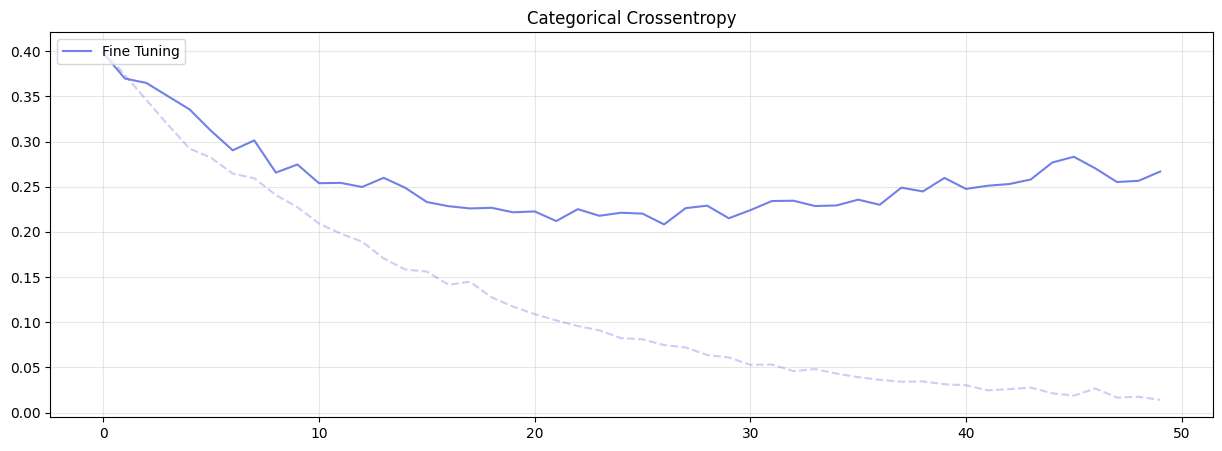

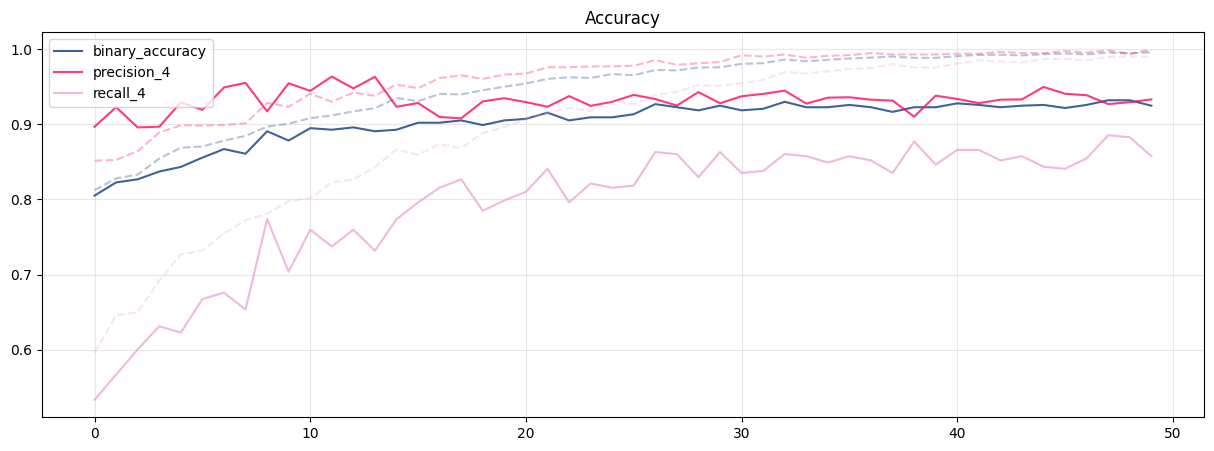

In [37]:
graph_history_file("ConvNetTiny_ft_history",  ['binary_accuracy', 'precision_4', 'recall_4',])

{'loss': [0.43867379426956177, 0.4112130403518677, 0.3924156725406647, 0.3665364980697632, 0.3549952805042267, 0.3424317240715027, 0.32893654704093933, 0.3263830542564392, 0.31012290716171265, 0.2975323498249054, 0.2885107398033142, 0.2719031274318695, 0.27202126383781433, 0.27229636907577515, 0.253254234790802, 0.24486297369003296, 0.24471478164196014, 0.23044463992118835, 0.2369651347398758, 0.22392457723617554, 0.20861485600471497, 0.20243492722511292, 0.19923919439315796, 0.18761497735977173, 0.17230266332626343, 0.17015953361988068, 0.1602305918931961, 0.1692662537097931, 0.1595946103334427, 0.14844755828380585, 0.13771578669548035, 0.14398764073848724, 0.13152949512004852, 0.12468466907739639, 0.11454726755619049, 0.11758865416049957, 0.11602039635181427, 0.10878556221723557, 0.10863294452428818, 0.09433434903621674, 0.09152532368898392, 0.08763832598924637, 0.08676792681217194, 0.08765577524900436, 0.07206396758556366, 0.07399917393922806, 0.07048258185386658, 0.0679103806614875

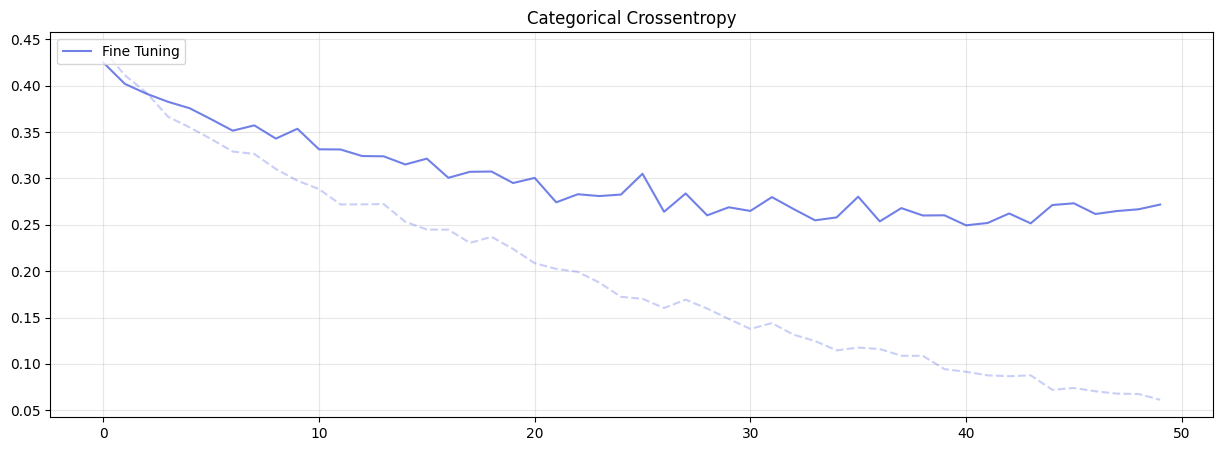

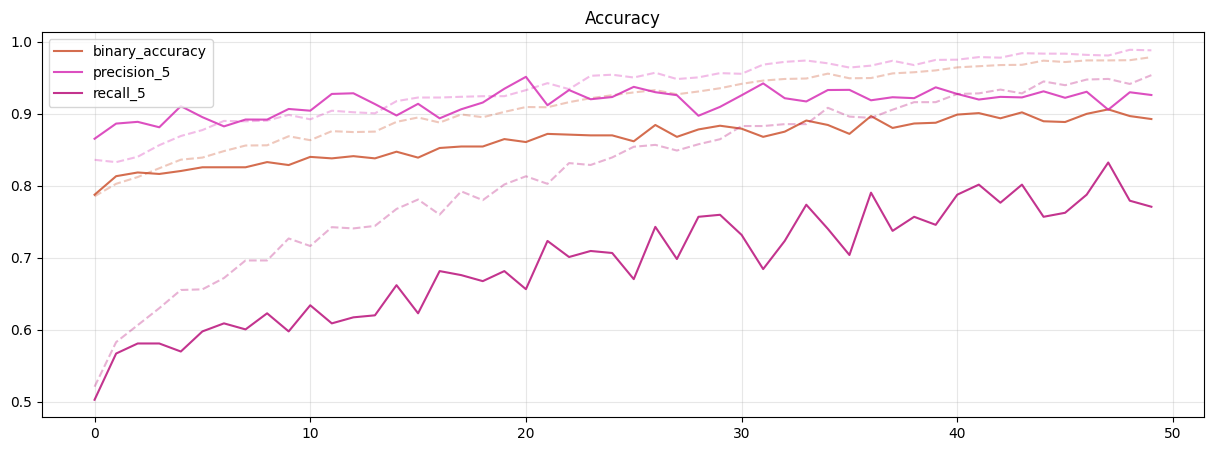

In [38]:
graph_history_file("ConvNetTiny_10_ft_history",  ['binary_accuracy', 'precision_5', 'recall_5',])

{'loss': [0.4425651431083679, 0.40368157625198364, 0.3638705313205719, 0.3414931297302246, 0.3346647322177887, 0.3056532144546509, 0.29954856634140015, 0.2664839029312134, 0.2662084102630615, 0.24591931700706482, 0.22730645537376404, 0.21684478223323822, 0.21224427223205566, 0.19117113947868347, 0.18583495914936066, 0.1762099266052246, 0.16160045564174652, 0.15477301180362701, 0.1473567932844162, 0.13708095252513885, 0.12650229036808014, 0.11543409526348114, 0.11051195114850998, 0.10403665155172348, 0.09983191639184952, 0.0932050347328186, 0.08294498920440674, 0.07984248548746109, 0.07290226221084595, 0.07196834683418274, 0.05649828910827637, 0.05741315335035324, 0.05626107379794121, 0.05054141581058502, 0.052739400416612625, 0.04653938114643097, 0.04300834611058235, 0.04123301059007645, 0.03723805770277977, 0.032353825867176056, 0.03526746854186058, 0.027888713404536247, 0.02750040777027607, 0.021069558337330818, 0.022286105901002884, 0.019898099824786186, 0.019497055560350418, 0.0197

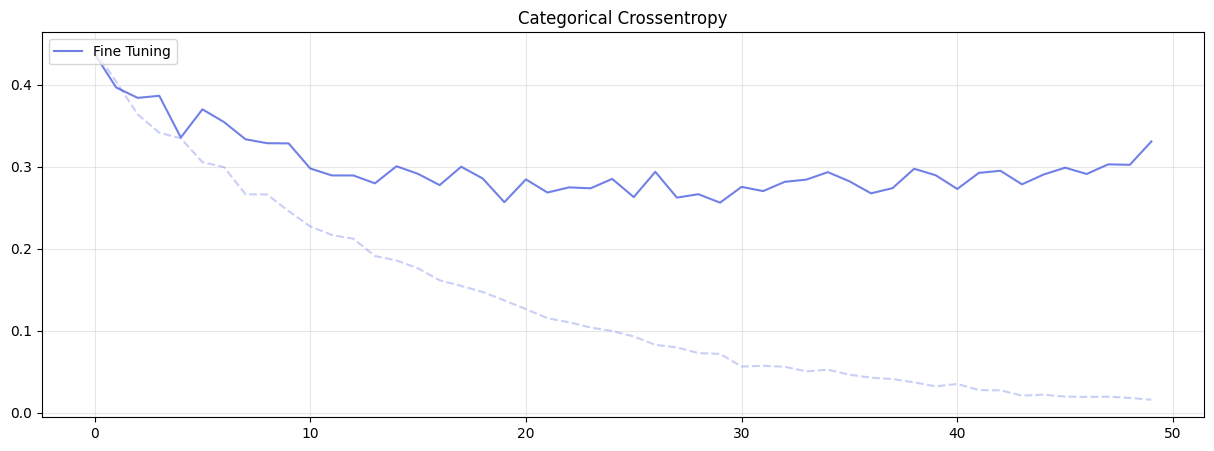

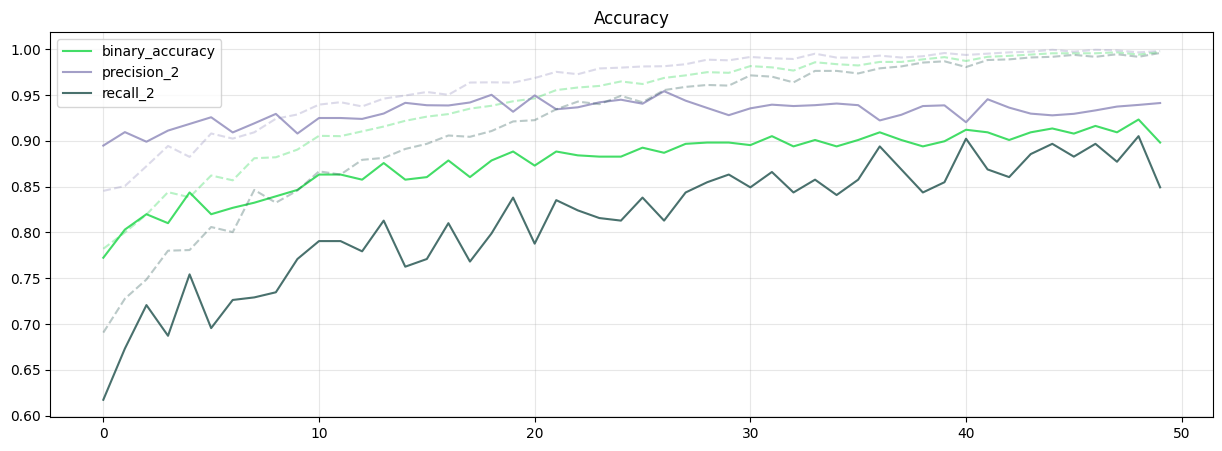

In [39]:
graph_history_file("ConvNetTiny_EQ_ft_history",  ['binary_accuracy', 'precision_2', 'recall_2',])


{'loss': [0.4416804909706116, 0.4061547517776489, 0.3802180886268616, 0.3648577928543091, 0.3462710976600647, 0.3180261254310608, 0.3141579329967499, 0.3000282943248749, 0.27548351883888245, 0.26215142011642456, 0.2611352503299713, 0.24742427468299866, 0.23437561094760895, 0.2346087247133255, 0.22138936817646027, 0.21312004327774048, 0.20153377950191498, 0.18447701632976532, 0.19028575718402863, 0.17649327218532562, 0.16093137860298157, 0.15735149383544922, 0.14211876690387726, 0.14193156361579895, 0.13405323028564453, 0.12507468461990356, 0.1278969645500183, 0.1180739477276802, 0.11095207929611206, 0.10794736444950104, 0.10767240077257156, 0.1003209725022316, 0.09671756625175476, 0.0894710049033165, 0.0957481637597084, 0.07916788011789322, 0.07821670919656754, 0.07342356443405151, 0.05979602038860321, 0.060968246310949326, 0.06794315576553345, 0.0632135272026062, 0.06365519016981125, 0.060476046055555344, 0.05444668233394623, 0.053604770451784134, 0.05965546518564224, 0.04511943459510

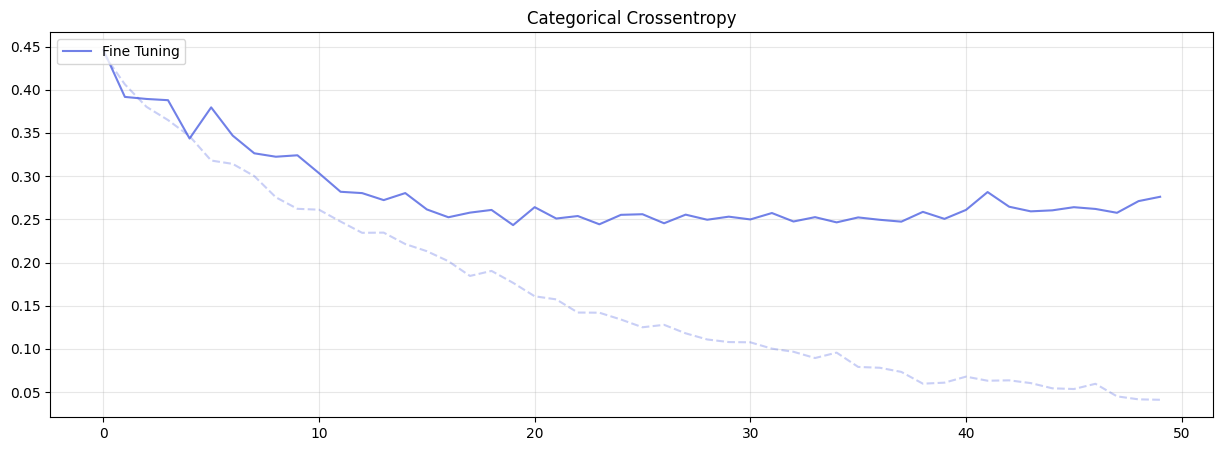

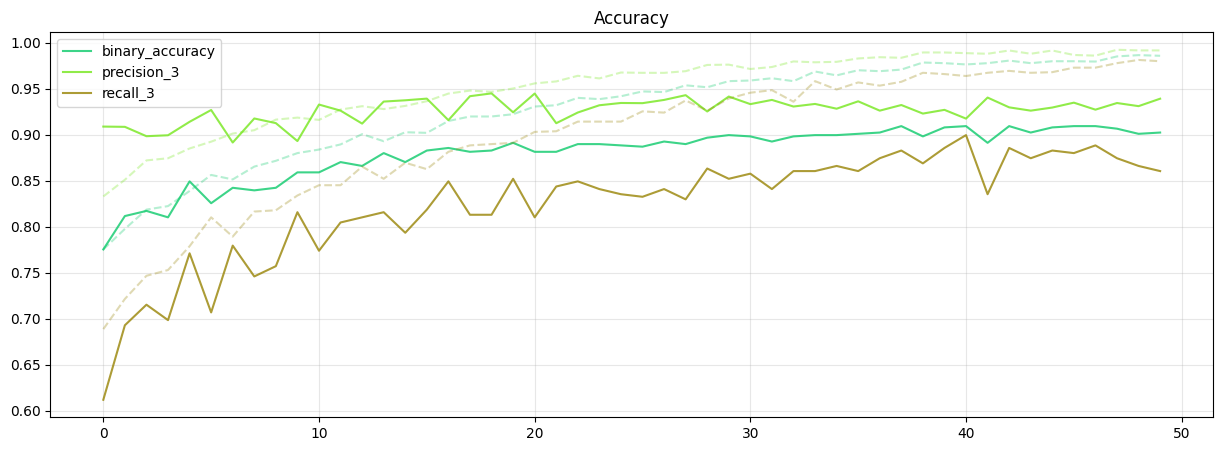

In [40]:
graph_history_file("ConvNetTiny_HeavyAug_EQ_ft_history",  ['binary_accuracy', 'precision_3', 'recall_3',])
